<a href="https://colab.research.google.com/github/valerian-drmt/Finance/blob/main/Projects/LSTM_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Setup Library and Import

In [1]:
!pip install vectorbt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import vectorbt as vbt
import time
import yfinance as yf
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from scipy.stats import norm
import plotly.express as px
from sklearn.metrics import confusion_matrix
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.6 MB/s eta 0:00:00


# 2) Get and Modify Data

| Interval       | Max Lookback Period (approx)  |
|----------------|-------------------------------|
| `'1m'`         | 7 days                        |
| `'2m'`         | 60 days                       |
| `'5m'`         | 60 days                       |
| `'15m'`        | 60 days                       |
| `'30m'`        | 60 days                       |
| `'60m'` / `'1h'` | 730 days (~2 years)        |
| `'1d'`         | ~20+ years                    |
| `'1wk'`        | ~20+ years                    |
| `'1mo'`        | ~20+ years                    |

Binance block request from codelab!!!

In [ ]:
# @title
# A UTILISER HORS DE CODELAB !!!!
def Binance_request():
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  from datetime import datetime,timedelta
  import vectorbt as vbt

  data_request = vbt.BinanceData.download(
      symbols="BTCUSDT",
      start="2024-03-10",
      end="2024-04-20",
      interval="5m",
  )

  # Extraire les données OHLCV sous forme de DataFrame
  df = data_request.get()

  print(df.index[0])
  print(df.head())

  # Make sure the index is timezone-naive
  if df.index.tz is not None:
      df.index = df.index.tz_localize(None)

  # Also remove timezone from datetime columns (if any)
  for col in df.columns:
      if pd.api.types.is_datetime64tz_dtype(df[col]):
          df[col] = df[col].dt.tz_localize(None)

  # Save to Excel
  df.to_excel("BTCUSDT_5m.xlsx", index=True)

In [41]:
from google.colab import files

# Choisis ton fichier à uploader
uploaded = files.upload()

# Remplace par le nom exact du fichier que tu as uploadé
data_v0 = pd.read_excel("BTCUSDT_5m.xlsx")

# Affiche les premières lignes
data_v0.head()
print(data_v0.columns)

Saving BTCUSDT_5m.xlsx to BTCUSDT_5m (4).xlsx
Index(['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
       'Quote volume', 'Number of trades', 'Taker base volume',
       'Taker quote volume'],
      dtype='object')


In [55]:
def extend_OHLC_in_data(data):
  input = pd.DataFrame(data = {"Open time" : data["Open time"],
                                "Open" :data["Open"],
                                "High": data["High"],
                                "Low": data["Low"],
                                "Close": data["Close"],
                                "Volume": data["Volume"],
                              })

  rows = [{"Open time": input.loc[0,"Open time"],
           "Price": input.loc[0, "Open"],
           "Volume": input.loc[0, "Volume"]/4
           }]

  for t, row in input.iterrows():
    t, o, h, l, c, v = row["Open time"], row["Open"], row["High"], row["Low"], row["Close"], row["Volume"]
    v_row = v/3

    if o >= c:
      values = [h,l,c]
    else:
      values = [l,h,c]

    for value in values:
      rows.append({"Open time": row["Open time"],
                  "Price": value,
                  "Volume": v_row})

  input = pd.DataFrame(rows)
  input.set_index("Open time", inplace=True)
  return input

In [58]:
data_v1 = extend_OHLC_in_data(data_v0)
print("Data_v0 Shape:",data_v0.shape)
print("Data_v1 Shape:",data_v1.shape)
print(data_v1)

Data_v0 Shape: (11808, 11)
Data_v1 Shape: (35425, 2)
                        Price     Volume
Open time                               
2024-03-09 22:00:00  68376.13  13.178735
2024-03-09 22:00:00  68381.04  17.571647
2024-03-09 22:00:00  68333.33  17.571647
2024-03-09 22:00:00  68375.96  17.571647
2024-03-09 22:05:00  68371.03   7.409820
...                       ...        ...
2024-04-19 21:50:00  64370.00  11.517700
2024-04-19 21:50:00  64359.00  11.517700
2024-04-19 21:55:00  64277.49  19.308573
2024-04-19 21:55:00  64398.32  19.308573
2024-04-19 21:55:00  64398.32  19.308573

[35425 rows x 2 columns]


### 🕒 Market Opening Hours (Paris Time)

| Market     | Opening Hours (Paris Time) | Opening Hours (UTC) |
|------------|-----------------------------|----------------------|
| 🇭🇰 **Hong Kong / Tokyo** | 01:00 – 07:00                    | 00:00 – 06:00         |
| 🇬🇧 **London**            | 09:00 – 17:30                    | 08:00 – 16:30         |
| 🇺🇸 **New York**          | 15:30 – 22:00                    | 13:30 – 20:00         |

> ⚠️ Note: Hours may shift by 1 hour during daylight saving time transitions.

   London_Open  NY_Open  HK_Open
0        24232    25707    26569
1        11193     9718     8856


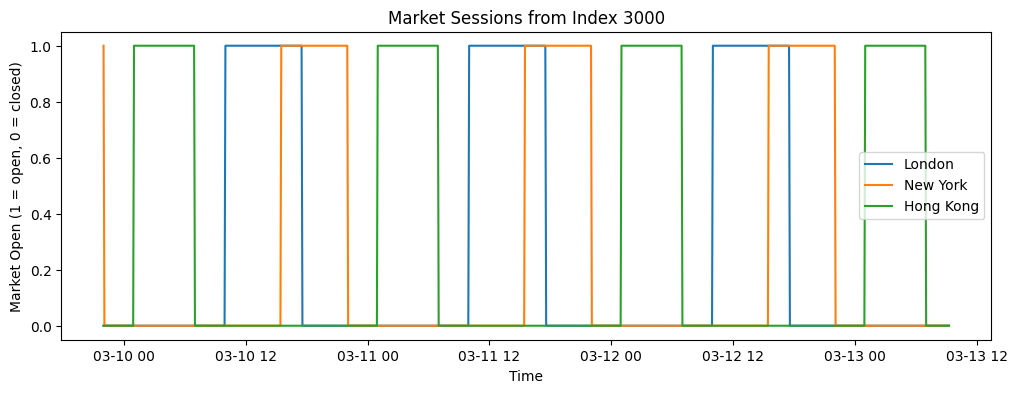

In [79]:
def mark_market_sessions(data):
    df = data.copy()
    # Ensure the datetime index is in datetime format and timezone-naive
    df.index = pd.to_datetime(df.index)
    df.index = df.index.tz_localize(None)

    # Functions to check if time is within a session
    def is_london_open(hour, minute):
        return (hour > 9 and hour < 17) or (hour == 17 and minute <= 30)

    def is_ny_open(hour, minute):
        return (hour >= 16 and hour < 22) or (hour == 15 and minute >= 30) or (hour == 22 and minute == 0)

    def is_tokyo_open(hour, minute):
        return (hour >= 1 and hour < 7)

    # Initialize columns
    london_open = []
    ny_open = []
    tokyo_open = []

    for timestamp in df.index:
        hour = timestamp.hour
        minute = timestamp.minute

        london_open.append(1 if is_london_open(hour, minute) else 0)
        ny_open.append(1 if is_ny_open(hour, minute) else 0)
        tokyo_open.append(1 if is_tokyo_open(hour, minute) else 0)

    df['London_Open'] = london_open
    df['NY_Open'] = ny_open
    df['HK_Open'] = tokyo_open

    return df

# Apply the updated function
data_v2 = mark_market_sessions(data_v1)
debug = True
if debug:
  frequency = data_v2[["London_Open", "NY_Open", "HK_Open"]].apply(lambda col: pd.Series(col).value_counts()).fillna(0).astype(int)
  print(frequency)
  nb = 3000
  plt.figure(figsize=(12, 4))
  plt.plot(data_v2["London_Open"].iloc[:nb], label="London")
  plt.plot(data_v2["NY_Open"].iloc[:nb], label="New York")
  plt.plot(data_v2["HK_Open"].iloc[:nb], label="Hong Kong")
  plt.legend()
  plt.title(f"Market Sessions from Index {nb}")
  plt.xlabel("Time")
  plt.ylabel("Market Open (1 = open, 0 = closed)")
  plt.show()

# Get Output

In [ ]:
def normal_pdf_frequencies(n, mean, std, range_std):
    """
    Use the Gaussian PDF to define relative weights for n bins centered around the mean.
    """
    # Define edges in terms of standard deviations
    edges = np.linspace(mean - range_std * std, mean + range_std * std, n + 1)
    midpoints = 0.5 * (edges[:-1] + edges[1:])
    pdf_values = norm.pdf(midpoints, loc=mean, scale=std)
    frequencies = pdf_values / np.sum(pdf_values)
    return frequencies.tolist(), edges

#-------------------------------------------------------------------------------

def verification_output(input,output):
  # Verification
  plt.figure(figsize=(12, 5))

  # Histogramme des future returns
  plt.subplot(1, 2, 1)
  plt.hist(input["Price"].pct_change(look_forward).dropna(), bins=30, color='skyblue', edgecolor='black')
  plt.title("Histogram of Future Returns")
  plt.xlabel("Future Return")
  plt.ylabel("Frequency")

  # Histogramme des catégories gaussiennes
  plt.subplot(1, 2, 2)
  plt.hist(output["Category"].dropna(), bins=np.arange(n+1)-0.5, color='salmon', edgecolor='black', rwidth=0.8)
  plt.xticks(range(n))
  plt.title("Histogram of Gaussian Categories")
  plt.xlabel("Category")
  plt.ylabel("Frequency")

  plt.tight_layout()
  plt.show()

#-------------------------------------------------------------------------------

def generate_output_category(input, category_frequencies, look_forward):
    """
    Parameters:
    - input: DataFrame with column "Price"
    - category_frequencies: list of floats (e.g. [0.2, 0.2, 0.2, 0.2, 0.2]) summing to 1
    - look_forward: horizon for future return
    """
    import pandas as pd
    import numpy as np

    output = pd.DataFrame(input["Price"])

    # Step 1: Calculate future returns and rolling stats
    output["Future Return"] = output["Price"].shift(-look_forward) / output["Price"] - 1
    output["Return Mean"] = output["Future Return"].rolling(window=look_forward).mean()
    output["Return Std"] = output["Future Return"].rolling(window=look_forward).std()
    output["Return Z-Score"] = (output["Future Return"] - output["Return Mean"]) / output["Return Std"]

    # Vérification que les fréquences personnalisées sont valides
    category_frequencies = np.array(category_frequencies)
    assert np.isclose(category_frequencies.sum(), 1.0), "Frequencies must sum to 1"

    # Step 2: Compute quantile boundaries from actual distribution
    valid_z = output["Return Z-Score"].dropna()
    cum_freq = np.cumsum(category_frequencies)
    quantile_cutoffs = valid_z.quantile(cum_freq[:-1])  # remove last 1.0
    boundaries = [-np.inf] + list(quantile_cutoffs.values) + [np.inf]

    # Step 3: Categorize Z-scores
    def categorize_zscore(z, bounds):
        if pd.isna(z):
            return np.nan
        for i in range(len(bounds) - 1):
            if bounds[i] <= z < bounds[i + 1]:
                return i

    output["Category"] = output["Return Z-Score"].apply(lambda z: categorize_zscore(z, boundaries))

    # Optional: cleanup
    output.drop(columns=["Price", "Future Return", "Return Mean", "Return Std", "Return Z-Score"], inplace=True)

    return output

          Category
Datetime          
0              NaN
0              NaN
0              NaN
0              NaN
1              NaN
1              NaN
1              NaN
2              NaN
2              NaN
2              NaN
3              NaN
3              NaN
3              NaN
4              NaN
4              NaN
4              NaN
5              NaN
5              NaN
5              NaN
6              1.0
6              1.0
6              2.0
7              2.0


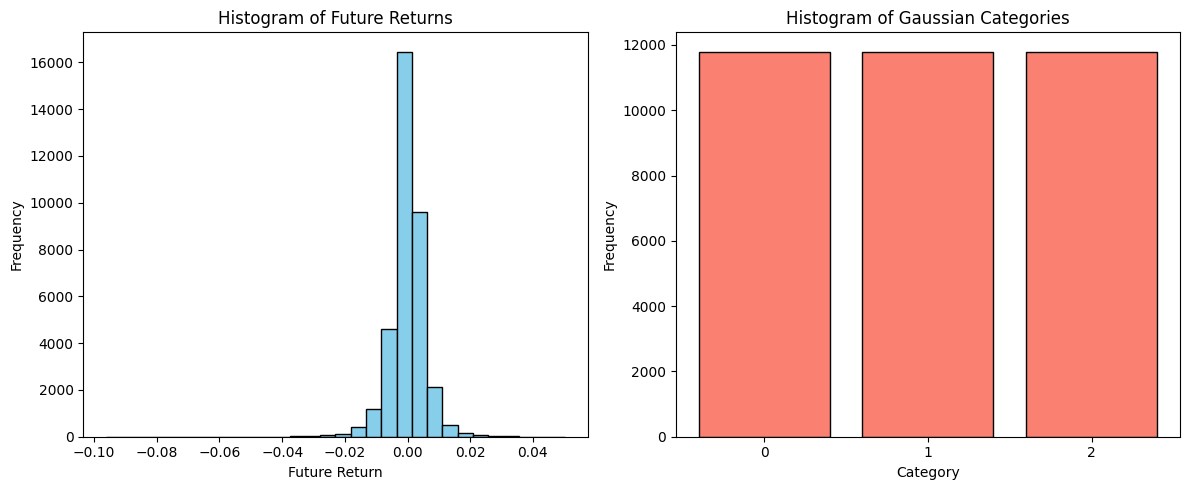

In [ ]:
# Parameters
n = 3  # number of categories
look_forward = 20

data_v1 = extend_OHLC_in_data(data_v0)
input = pd.DataFrame(data_v1["Price"])

output = generate_output_category(input, [1/n]*n, look_forward)

print(output.head(n + look_forward))
verification_output(input,output)

# Generate Train and Test Data

In [ ]:
train_test_data = pd.DataFrame({"Input_1": input["Price"],
                                "Output_1": output["Category"]
                                }).dropna()
print("Train/Test Size:", len(train_test_data))
print(train_test_data.head())

Train/Test Size: 35386
           Input_1  Output_1
Datetime                    
6         68390.34       1.0
6         68351.99       1.0
6         68352.00       2.0
7         68351.99       2.0
7         68379.51       2.0


In [ ]:
# @title
def split_data(train_test_data, lookback, size_test_prct):
    # 1. Séparer features et labels
    features = train_test_data["Input_1"].values.reshape(-1, 1)  # shape (N, 1)
    labels = train_test_data["Output_1"].values.reshape(-1, 1)   # shape (N, 1)

    # 2. Normaliser uniquement les features
    features = (features - features.min()) / (features.max() - features.min())

    # 3. Recomposer les données normalisées + labels
    data_all = np.hstack((features, labels))  # shape (N, 2)

    # 4. Création des séquences
    data = []
    for index in range(len(data_all) - lookback):
        data.append(data_all[index: index + lookback])

    data = np.array(data)

    # 5. Split train / test
    test_set_size = int(np.round(size_test_prct * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size

    x_train = data[:train_set_size, :, :-1]     # Toutes les colonnes sauf Output_1
    y_train = data[:train_set_size, -1, -1]      # Dernière valeur de Output_1
    x_test = data[train_set_size:, :, :-1]
    y_test = data[train_set_size:, -1, -1]

    # 6. Conversion en tenseurs PyTorch
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).long()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long()

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = split_data(train_test_data, 20, 0.3)
y_train_series = pd.Series(y_train.cpu().numpy())
frequency = y_train_series.value_counts().sort_index()
print(frequency)

0    8214
1    8328
2    8214
Name: count, dtype: int64


# 3) Setup LSTM Definition

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()

        self.num_layers = num_layers
        self.lstm_layers = nn.ModuleList()

        # Première couche LSTM
        self.lstm_layers.append(nn.LSTM(input_dim, hidden_dim[0], batch_first=True))

        # Couches suivantes
        for i in range(1, self.num_layers):
            self.lstm_layers.append(nn.LSTM(hidden_dim[i-1], hidden_dim[i], batch_first=True))

        # Couche linéaire finale
        self.fc = nn.Linear(hidden_dim[-1], output_dim)

    def forward(self, x):
        out = x
        for lstm in self.lstm_layers:
            out, _ = lstm(out)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

Function to Delete Training Data Variables

In [ ]:
# @title
def del_train_data(list):
  for var in list:
    if var in locals():
        del globals()[var]

Function to Initialize Metrics Tracking

In [ ]:
# @title
def metrics_setup():
    criterion = nn.CrossEntropyLoss()

    # Dictionnaires pour stocker les métriques
    hist_criterion = np.zeros(num_epochs)
    hist_acc = np.zeros(num_epochs)
    hist_f1 = np.zeros(num_epochs)
    hist_precision = np.zeros(num_epochs)
    hist_recall = np.zeros(num_epochs)

    return criterion, hist_criterion, hist_acc, hist_f1, hist_precision, hist_recall

Function to Update Model Metrics

In [ ]:
# @title
def update_metrics(y_train_pred, y_train, criterion):
    loss = criterion(y_train_pred, y_train)

    y_pred = torch.argmax(y_train_pred, dim=1)

    y_pred_np = y_pred.detach().cpu().numpy()
    y_true_np = y_train.detach().cpu().numpy()

    acc = accuracy_score(y_true_np, y_pred_np)
    f1 = f1_score(y_true_np, y_pred_np, average='weighted')
    precision = precision_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
    recall = recall_score(y_true_np, y_pred_np, average='weighted', zero_division=0)


    return loss, acc, f1, precision, recall

# 4) Setup Data Pisplay Definition

Function to Plot Training Metrics Over Epochs

In [ ]:
# @title
def plot_metrics(hist_acc, hist_f1, hist_precision, hist_recall, hist_criterion):
    metrics = [hist_acc, hist_f1, hist_precision, hist_recall, hist_criterion]
    titles = ['Accuracy', 'F1-score', 'Precision', 'Recall', 'CrossEntropy Loss']
    colors = ['blue', 'green', 'orange', 'purple', 'red']
    ylabel = ['Score'] * 4 + ['Loss']

    epochs = range(1, len(hist_acc) + 1)
    fig, axs = plt.subplots(1, 5, figsize=(22, 4))

    for i, ax in enumerate(axs):
        ax.plot(epochs, metrics[i], color=colors[i])
        ax.set_title(titles[i])
        ax.set_xlabel('Epoch')
        ax.set_ylabel(ylabel[i])
        ax.grid(True)

    plt.tight_layout()
    plt.suptitle('Training Metrics per Epoch', fontsize=16, y=1.05)
    plt.show()

Function to Plot Model Predictions Against Actual Data

In [ ]:
# @title
def visualize_classification_results(y_true, y_pred, output_dim, sequence_title="True vs Predicted", max_points=150):
    """
    Affiche :
    - Matrice de confusion (heatmap)
    - Séquence de classes (true vs pred) sur les derniers points
    - Histogramme de distribution des classes

    Compatible avec Google Colab / Jupyter
    """

    # Convertir en NumPy si Tensor
    if hasattr(y_true, 'detach'):
        y_true = y_true.detach().cpu().numpy()
    if hasattr(y_pred, 'detach'):
        y_pred = y_pred.detach().cpu().numpy()

    # Créer la figure avec 3 sous-graphes côte à côte
    fig, axs = plt.subplots(1, 3, figsize=(22, 5))
    plt.subplots_adjust(wspace=0.4)

    # -------------------------------
    # 1. MATRICE DE CONFUSION
    cm = confusion_matrix(y_true, y_pred, labels=range(output_dim))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(range(output_dim)),
                yticklabels=list(range(output_dim)),
                ax=axs[0])
    axs[0].set_xlabel("Predicted")
    axs[0].set_ylabel("Actual")
    axs[0].set_title("Confusion Matrix")

    # -------------------------------
    # 2. Séquence de classes
    axs[1].plot(y_true[-max_points:], label='True', marker='o')
    axs[1].plot(y_pred[-max_points:], label='Predicted', marker='x', linestyle='--')
    axs[1].set_title(f"{sequence_title} (last {max_points} samples)")
    axs[1].set_xlabel("Sample Index")
    axs[1].set_ylabel("Class")
    axs[1].legend()
    axs[1].grid(True)

    # -------------------------------
    # 3. Histogramme des classes
    true_counts = pd.Series(y_true).value_counts().sort_index().reindex(range(output_dim), fill_value=0)
    pred_counts = pd.Series(y_pred).value_counts().sort_index().reindex(range(output_dim), fill_value=0)

    bar_width = 0.35
    classes = np.arange(output_dim)

    axs[2].bar(classes - bar_width/2, true_counts, width=bar_width, label='True Labels')
    axs[2].bar(classes + bar_width/2, pred_counts, width=bar_width, label='Predicted Labels')
    axs[2].set_xlabel("Class")
    axs[2].set_ylabel("Count")
    axs[2].set_title("Class Distribution")
    axs[2].set_xticks(classes)
    axs[2].legend()
    axs[2].grid(axis='y')

    plt.show()

Function to Display Model Performance Metrics

In [ ]:
# @title
def show_final_metrics():
    # Conversion en NumPy
    y_test_np = y_test.detach().cpu().numpy()
    y_pred_np = y_test_pred.detach().cpu().numpy()

    # Métriques test
    acc_test = accuracy_score(y_test_np, y_pred_np)
    f1_test = f1_score(y_test_np, y_pred_np, average='weighted')
    precision_test = precision_score(y_test_np, y_pred_np, average='weighted', zero_division=0)
    recall_test = recall_score(y_test_np, y_pred_np, average='weighted', zero_division=0)
    loss_test = criterion(y_test_pred_list, y_test).item()

    # Moyenne des métriques train
    acc_train = np.mean(hist_acc[-int(num_epochs * 0.2):])
    f1_train = np.mean(hist_f1[-int(num_epochs * 0.2):])
    precision_train = np.mean(hist_precision[-int(num_epochs * 0.2):])
    recall_train = np.mean(hist_recall[-int(num_epochs * 0.2):])
    loss_train = np.mean(hist_criterion[-int(num_epochs * 0.2):])

    # Tableau final
    metrics_data = {
        'Train': [acc_train, f1_train, precision_train, recall_train, loss_train],
        'Test':  [acc_test, f1_test, precision_test, recall_test, loss_test]
    }

    metrics_df = pd.DataFrame(metrics_data, index=['Accuracy', 'F1-score', 'Precision', 'Recall', 'Loss'])

    print("\n📊 Résumé des métriques de classification :\n")
    print(metrics_df.round(4))

# 5) Train, Test and Plot LSTM Model

à rajouter:
- feature +3 dims : 3 dims valeur (0 ou 1) pour les 3 marché NY,London et HK
- feature +4 dims : 4 dims 2 high, 2 low
- feature +1 à 3 dims : vwap pour les variations H->L et L->H
- label +2 dims : On a deja le close, il faut le high et le low

régulateur pour la perf:
- ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
- torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
- nn.Dropout(p=0.3)

-----------------------------------------------------------------------
Train/Test Size: 4462
-----------------------------------------------------------------------
           Input_1  Output_1
Datetime                    
10314     63077.00       3.0
10314     64030.31       2.0
10314     63725.47       2.0
10315     63555.55       2.0
10315     64212.13       1.0
-----------------------------------------------------------------------
Output_1
0.0     638
1.0     956
2.0    1274
3.0     956
4.0     638
Name: count, dtype: int64
-----------------------------------------------------------------------


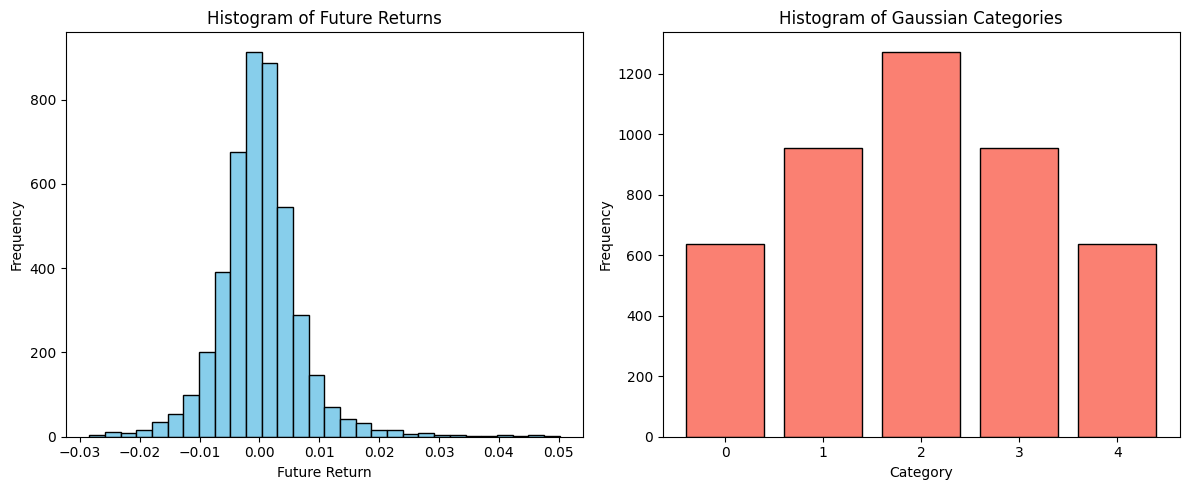

-----------------------------------------------------------------------


In [ ]:
# @title
lookback = 100
look_forward = int(lookback*0.2)
size_test_prct = 0.3
input_dim = 1
hidden_dim = [32,32]
num_layers = len(hidden_dim)
num_epochs = 50
n = 5  # number of category (odd value)
output_dim = n #car on est en crosslossentity

#-------------------------------------------------------------------------------
# Calculate category_frequencies
half = n // 2
values = np.concatenate([np.linspace(1, half, half, endpoint=False), np.linspace(half, 1, n - half)])
values /= values.sum()  # Normalisation pour que la somme = 1
category_frequencies = values

#-------------------------------------------------------------------------------

data_v1 = extend_OHLC_in_data(data_v0[-1500:])
input = pd.DataFrame(data_v1["Price"])
output = generate_output_category(input, category_frequencies, look_forward)
train_test_data = pd.DataFrame({"Input_1": input["Price"],
                                "Output_1": output["Category"]
                                }).dropna()
x_train, y_train, x_test, y_test = split_data(train_test_data, lookback, size_test_prct)

#-------------------------------------------------------------------------------
#Verification

debug = False
if debug:
  print("-----------------------------------------------------------------------")
  print("data_v0 size:",len(data_v0))
  print("-----------------------------------------------------------------------")
  print(data_v0.head())
  print("-----------------------------------------------------------------------")
  print("data_v1 size:",len(data_v1))
  print("-----------------------------------------------------------------------")
  print(data_v1.head())
  print("-----------------------------------------------------------------------")
  print(input.head())
  print(output.head())
  print("-----------------------------------------------------------------------")
  print(x_train.shape)
  y_train_series = pd.Series(y_train.cpu().numpy())
  frequency = y_train_series.value_counts().sort_index()
  print(frequency)


print("-----------------------------------------------------------------------")
print("Train/Test Size:", len(train_test_data))
print("-----------------------------------------------------------------------")
print(train_test_data.head())
print("-----------------------------------------------------------------------")
frequency = train_test_data["Output_1"].value_counts().sort_index()
print(frequency)
print("-----------------------------------------------------------------------")
verification_output(input,output)
print("-----------------------------------------------------------------------")

---------------------------------
Epoch 1 / Loss: 1.5893 / Acc: 0.2923 / F1: 0.1322 / Precision: 0.0854 / Recall: 0.2923
Epoch 10 / Loss: 1.5673 / Acc: 0.2923 / F1: 0.1322 / Precision: 0.0854 / Recall: 0.2923
Epoch 20 / Loss: 1.5587 / Acc: 0.2962 / F1: 0.1570 / Precision: 0.1661 / Recall: 0.2962
Epoch 30 / Loss: 1.5535 / Acc: 0.3056 / F1: 0.1816 / Precision: 0.1628 / Recall: 0.3056
Epoch 40 / Loss: 1.5368 / Acc: 0.3130 / F1: 0.2055 / Precision: 0.3802 / Recall: 0.3130
Epoch 50 / Loss: 1.4788 / Acc: 0.3302 / F1: 0.2620 / Precision: 0.2569 / Recall: 0.3302
---------------------------------
Training time: 88.76803421974182
---------------------------------

📊 Résumé des métriques de classification :

            Train    Test
Accuracy   0.3207  0.2442
F1-score   0.2308  0.1336
Precision  0.2658  0.1266
Recall     0.3207  0.2442
Loss       1.5098  1.7774
---------------------------------
Accuracy = proportion de prédictions correctes sur l’ensemble des classes.
Precision = parmi les prédic

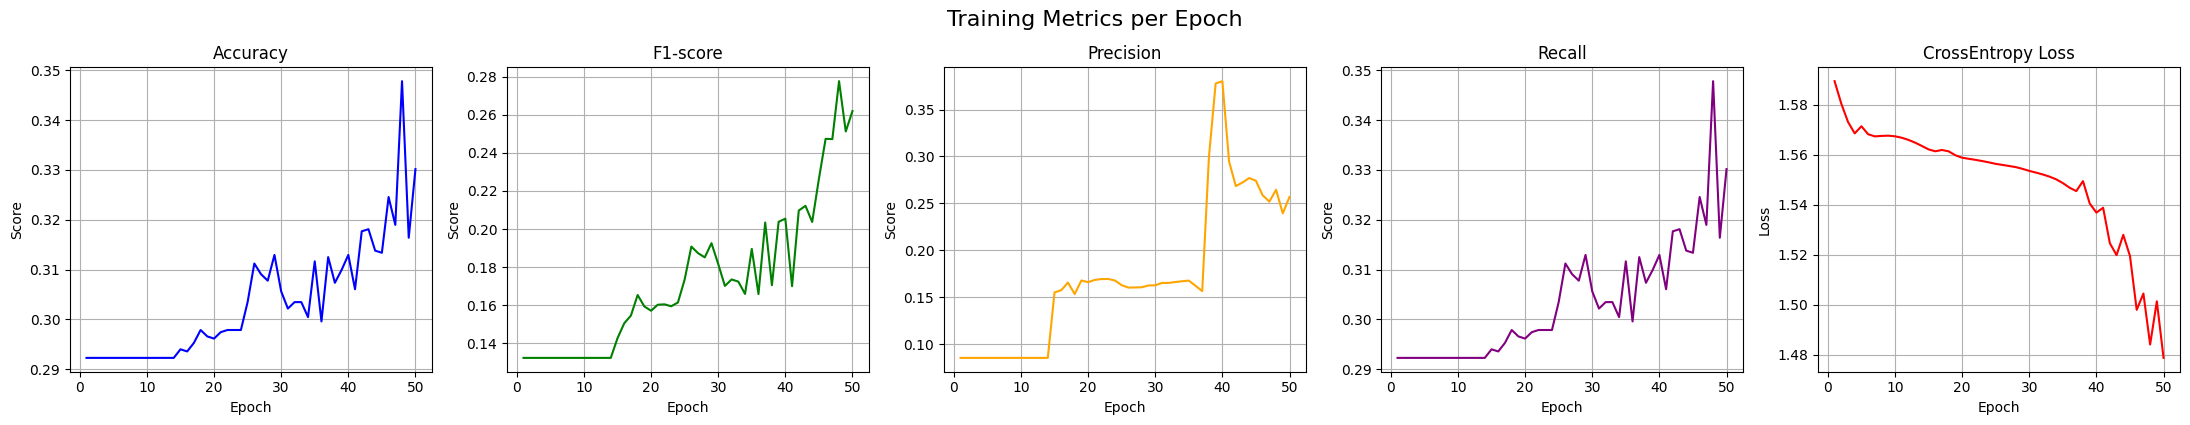

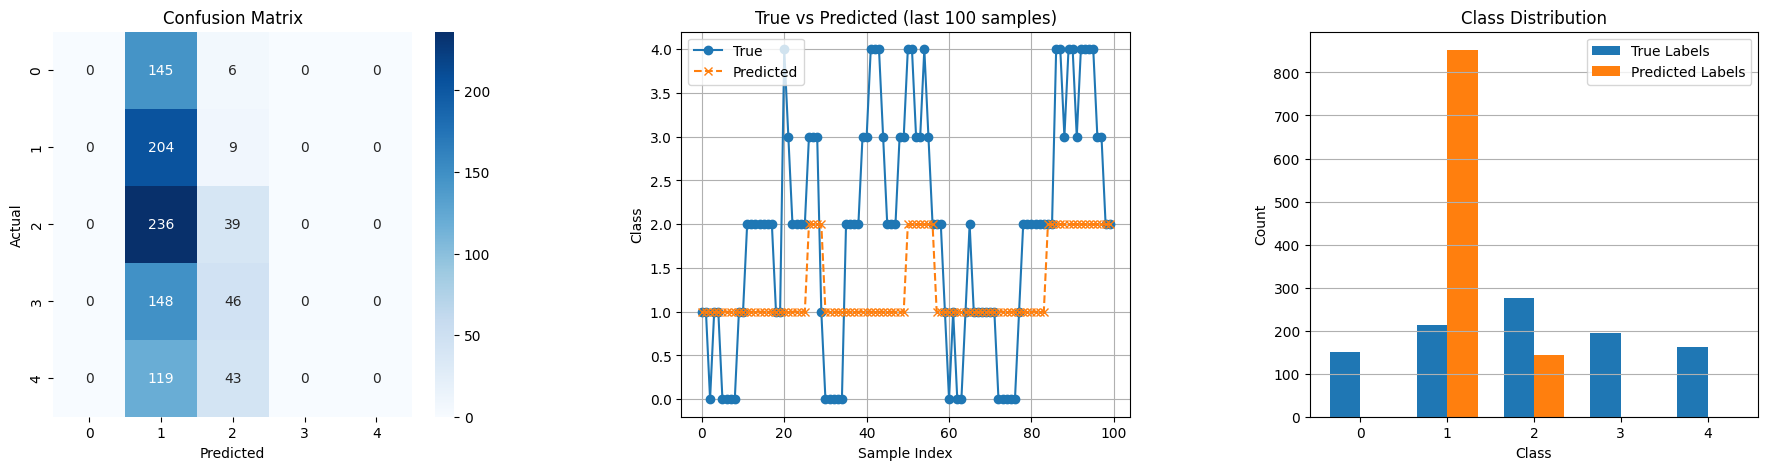

In [ ]:
# Supprimer les data du train précédent
del_train_data(['model', 'optimiser', 'criterion'])

#-------------------------------------------------------------------------------
# Model Setup
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# Loss function and metric history setup
criterion, hist_criterion, hist_acc, hist_f1, hist_precision, hist_recall = metrics_setup()

print("---------------------------------")
start_time = time.time()
for t in range(num_epochs):
    model.train()
    y_train_pred = model(x_train)

    # Compute loss and classification metrics
    loss, acc, f1, prec, rec = update_metrics(y_train_pred, y_train, criterion)

    hist_criterion[t] = loss.item()
    hist_acc[t] = acc
    hist_f1[t] = f1
    hist_precision[t] = prec
    hist_recall[t] = rec

    # Logging
    if (t+1) % 10 == 0 or t == 0:
        print(f"Epoch {t+1} / Loss: {hist_criterion[t].item():.4f} / Acc: {hist_acc[t]:.4f} / F1: {hist_f1[t]:.4f} / Precision: {hist_precision[t]:.4f} / Recall: {hist_recall[t]:.4f}")

    # Backpropagation
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("---------------------------------\nTraining time: {}\n---------------------------------".format(training_time))

#-------------------------------------------------------------------------------

model.eval()
with torch.no_grad():
    y_test_pred_list = model(x_test)                             # shape: [batch_size, n]
    y_test_pred = torch.argmax(y_test_pred_list, dim=1)          # shape: [batch_size]

#-------------------------------------------------------------------------------

# Affichage des métriques
show_final_metrics()
print("---------------------------------")
print("Accuracy = proportion de prédictions correctes sur l’ensemble des classes.")
print("Precision = parmi les prédictions positives, combien sont réellement correctes.")
print("Recall = parmi les vrais positifs, combien le modèle a réussi à capturer.")
print("F1-score = compromis entre precision et recall, utile en cas de classes déséquilibrées.")
print("Loss = mesure l’erreur globale du modèle, plus elle est basse, mieux c’est.")
print("---------------------------------")
# Nouveau : appel à plot_metrics avec les bonnes métriques classification
plot_metrics(hist_acc, hist_f1, hist_precision, hist_recall, hist_criterion)

visualize_classification_results(y_test, y_test_pred, output_dim, sequence_title="True vs Predicted", max_points=lookback)
#-------------------------------------------------------------------------------